In [1]:
import numpy as np 
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE 
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

image_path = os.path.join("../input/data/Lung Segmentation/CXR_png")
mask_path = os.path.join("../input/data/Lung Segmentation/","masks/")

In [2]:
# we have 704 masks but 800 images. Hence we are going to
# make a 1-1 correspondance from mask to images, not the usual other way.
images = os.listdir(image_path)
mask = os.listdir(mask_path)
mask = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask]
len(image_file_name)

704

In [3]:
check = [i for i in mask if "mask" in i]
print("Total mask that has modified name:",len(check))

Total mask that has modified name: 566


In [4]:
testing_files = set(os.listdir(image_path)) & set(os.listdir(mask_path))
training_files = check

In [5]:
def getData(X_shape, flag = "test"):
    im_array = []
    mask_array = []
    
    if flag == "test":
        for i in tqdm(testing_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i), 0),(X_shape,X_shape))
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i), 0),(X_shape,X_shape))
            
            im_array.append(im)
            mask_array.append(mask)
        
        return im_array,mask_array
    
    if flag == "train":
        for i in tqdm(training_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i.split("_mask")[0]+".png"), 0),(X_shape,X_shape))
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i+".png"), 0),(X_shape,X_shape))

            im_array.append(im)
            mask_array.append(mask)

        return im_array,mask_array

In [6]:
#perform sanity check

def plotMask(X,y):
    sample = []
    
    for i in range(6):
        left = X[i]
        right = y[i]
        combined = np.hstack((left,right))
        sample.append(combined)
        
        
    for i in range(0,6,3):

        plt.figure(figsize=(25,10))
        
        plt.subplot(2,3,1+i)
        plt.imshow(sample[i], cmap='gray')
        
        plt.subplot(2,3,2+i)
        plt.imshow(sample[i+1], cmap='gray')
        
        
        plt.subplot(2,3,3+i)
        plt.imshow(sample[i+2], cmap='gray')
        
        plt.show()

In [7]:
# Load training and testing data
dim = 256*2
X_train,y_train = getData(dim,flag="train")
X_test, y_test = getData(dim)

100%|██████████| 138/138 [00:39<00:00,  3.48it/s]


# Perform Sanity Check

training set


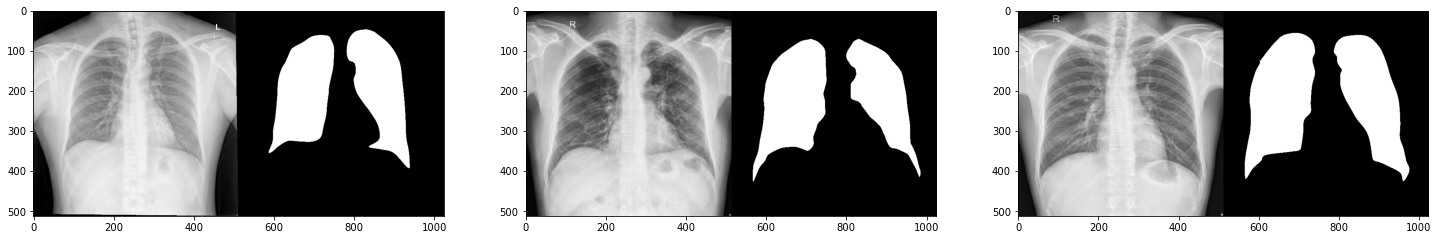

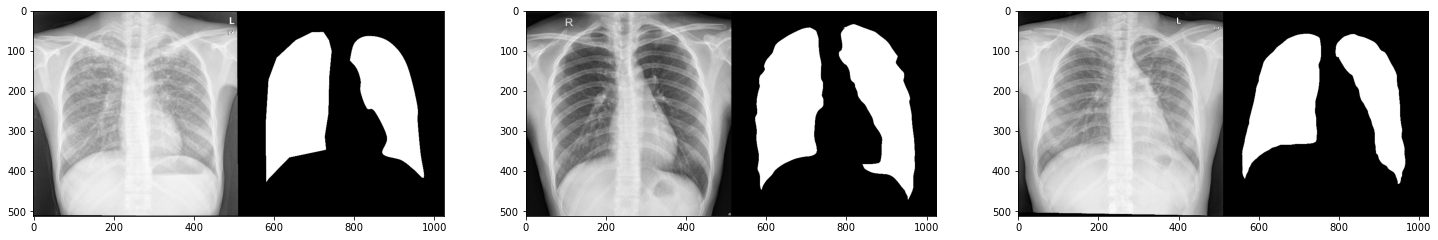

testing set


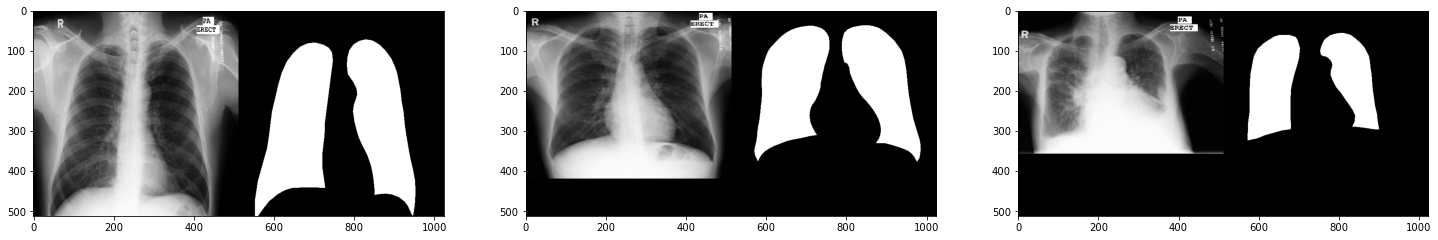

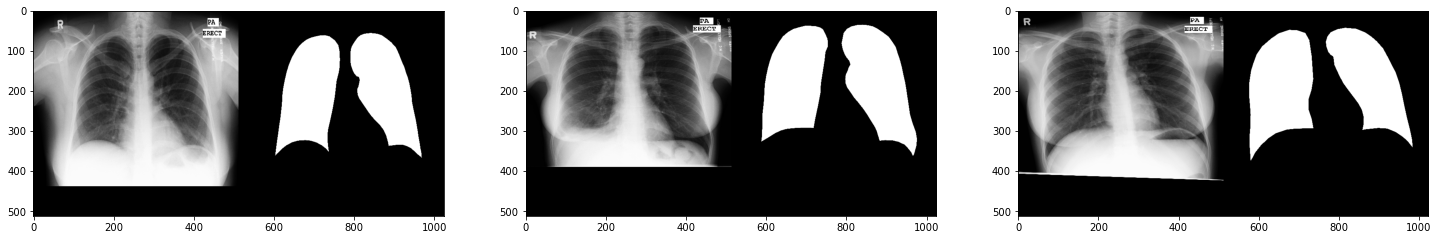

In [8]:
print("training set")
plotMask(X_train,y_train)
print("testing set")
plotMask(X_test,y_test)

Both the sets looks correct. Let's combine them and further use them as a unified dataset.

In [9]:
X_train = np.array(X_train).reshape(len(X_train),dim,dim,1)
y_train = np.array(y_train).reshape(len(y_train),dim,dim,1)
X_test = np.array(X_test).reshape(len(X_test),dim,dim,1)
y_test = np.array(y_test).reshape(len(y_test),dim,dim,1)
assert X_train.shape == y_train.shape
assert X_test.shape == y_test.shape
images = np.concatenate((X_train,X_test),axis=0)
mask  = np.concatenate((y_train,y_test),axis=0)

Loss Function 

In [10]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler


def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

def compute_iou(im1, im2):
    overlap = tf.logical_and(im1>0.5, im2>0.5)
    union = tf.logical_or(im1>0.5, im2>0.5)
    overlap = tf.cast(overlap, tf.float32)
    union = tf.cast(union, tf.float32)
    return tf.reduce_sum(overlap)/tf.reduce_sum(union)

## Define  the network and callbacks

I am going to use my favourite segmentation network - U-Nets. You can read about them [here](https://arxiv.org/abs/1505.04597).

In [11]:
def unetpp(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1_1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_1)

    conv2_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2_1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2_1)
    
    up1_2 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], axis=3)
    conv1_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1_2)
    conv1_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1_2)

    conv3_1 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3_1 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3_1)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3_1)
    
    up2_2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], axis=3)
    conv2_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2_2)
    conv2_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2_2)
    
    up1_3 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], axis=3)
    conv1_3 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1_3)
    conv1_3 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1_3)

    conv4_1 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4_1 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4_1)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4_1)
    
    up3_2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], axis=3)
    conv3_2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3_2)
    conv3_2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3_2)
    
    up2_3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], axis=3)
    conv2_3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2_3)
    conv2_3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2_3)
    
    up1_4 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], axis=3)
    conv1_4 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1_4)
    conv1_4 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1_4)

    conv5_1 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5_1 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5_1)

    up4_2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], axis=3)
    conv4_2 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4_2)
    conv4_2 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4_2)
    
    up3_3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], axis=3)
    conv3_3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3_3)
    conv3_3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3_3)
    
    up2_4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], axis=3)
    conv2_4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2_4)
    conv2_4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2_4)
    
    up1_5 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], axis=3)
    conv1_5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1_5)
    conv1_5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1_5)
    
    #nestnet_output_1 = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(conv1_2)
    #nestnet_output_2 = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(conv1_3)
    #nestnet_output_3 = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(conv1_4)
    nestnet_output_4 = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(conv1_5)

    return Model(inputs=[inputs], outputs=[nestnet_output_4])

#### Compile and train the Unet Model

In [12]:
model = unetpp(input_size=(512,512,1))
model.compile(optimizer=Adam(lr=2e-4), 
              loss=[bce_dice_loss], 
           metrics = [dice_coef, compute_iou])

## Callbacks, Early Stopping and Reduced LR


In [13]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_compute_iou", 
                      mode="max", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

# Train the model

In [14]:
from IPython.display import clear_output
from keras.optimizers import Adam 
from sklearn.model_selection import train_test_split

train_vol, validation_vol, train_seg, validation_seg = train_test_split((images)/255.0, 
                                                            (mask/255.0>0.5).astype(np.float32), 
                                                            test_size = 0.1,random_state = 2018)

train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol,train_seg, 
                                                            test_size = 0.1, 
                                                            random_state = 2018)


In [15]:
loss_history = model.fit(x = train_vol,
                       y = train_seg,
                         batch_size = 8,
                  epochs = 50,
                  validation_data =(test_vol,test_seg) ,
                  callbacks=callbacks_list)

Epoch 1/50
72/72 [==============================] - ETA: 0s - loss: -0.0660 - dice_coef: 0.3396 - compute_iou: 0.0157
Epoch 00001: val_loss improved from inf to -0.24975, saving model to cxr_reg_weights.best.hdf5
72/72 [==============================] - 61s 848ms/step - loss: -0.0660 - dice_coef: 0.3396 - compute_iou: 0.0157 - val_loss: -0.2497 - val_dice_coef: 0.4380 - val_compute_iou: 0.3060 - lr: 2.0000e-04
Epoch 2/50
72/72 [==============================] - ETA: 0s - loss: -0.4951 - dice_coef: 0.6561 - compute_iou: 0.6418
Epoch 00002: val_loss improved from -0.24975 to -0.67811, saving model to cxr_reg_weights.best.hdf5
72/72 [==============================] - 59s 821ms/step - loss: -0.4951 - dice_coef: 0.6561 - compute_iou: 0.6418 - val_loss: -0.6781 - val_dice_coef: 0.8091 - val_compute_iou: 0.7166 - lr: 2.0000e-04
Epoch 3/50
72/72 [==============================] - ETA: 0s - loss: -0.7152 - dice_coef: 0.8263 - compute_iou: 0.7443
Epoch 00003: val_loss did not improve from -0.678

## Plot the metric and evaluate 

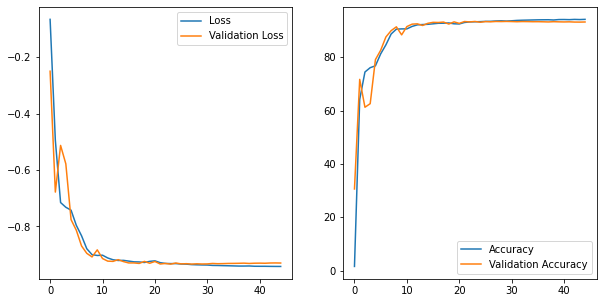

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(loss_history.history['compute_iou']), '-', 
         label = 'Accuracy')
ax2.plot(100*np.array(loss_history.history['val_compute_iou']), '-',
         label = 'Validation Accuracy')
ax2.legend()

In [17]:
model.evaluate(validation_vol, validation_seg, batch_size=8)

9/9 [==============================] - 3s 384ms/step - loss: -0.9190 - dice_coef: 0.9553 - compute_iou: 0.9230


[-0.9189537763595581, 0.955290675163269, 0.9230425953865051]

## Test the model

In [18]:
pred_candidates = np.random.randint(1,validation_vol.shape[0],10)
preds = (model.predict(validation_vol)>0.5).astype(int)

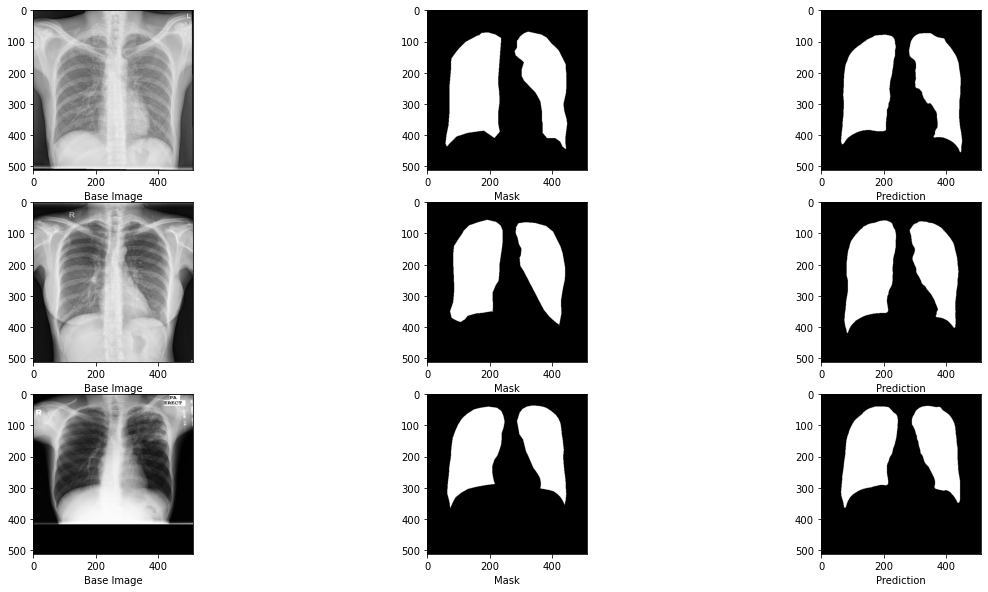

In [19]:
plt.figure(figsize=(20,10))

for i in range(0,9,3):
    plt.subplot(3,3,i+1)
    
    plt.imshow(np.squeeze(validation_vol[pred_candidates[i]]), cmap='gray')
    plt.xlabel("Base Image")
    
    
    plt.subplot(3,3,i+2)
    plt.imshow(np.squeeze(validation_seg[pred_candidates[i]]), cmap='gray')
    plt.xlabel("Mask")
    
    plt.subplot(3,3,i+3)
    plt.imshow(np.squeeze(preds[pred_candidates[i]]), cmap='gray')
    plt.xlabel("Prediction")